In [1]:
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

Reading in our potential test sets from [here](https://huggingface.co/datasets/imageomics/lila-bc-camera/tree/d18307b285217d18b31d1a7b2c9091bb0873ade0/data/potential-test-sets):
  - [Ohio Small Animals](https://lila.science/datasets/ohio-small-animals/)
  - [Desert Lion Conservation Camera Traps](https://lila.science/datasets/desert-lion-conservation-camera-traps/)
  - [Orinoquia Camera Traps](https://lila.science/datasets/orinoquia-camera-traps/)
  - [Island Conservation Camera Traps](https://lila.science/datasets/island-conservation-camera-traps/)
  - [ENA24](https://lila.science/datasets/ena24detection)

We'll clean them down to just the taxa and identifier columns, then further reduce to make balanced test sets for each.

# Island Conservation Camera Traps Datasets
upper/lower bounded and balanced

In [2]:
df = pd.read_csv("../data/potential-test-sets/Island_Conservation_Camera_Traps_image_urls_and_labels.csv", low_memory = False)
df.head()

dataset_name  \
0  Island Conservation Camera Traps   
1  Island Conservation Camera Traps   
2  Island Conservation Camera Traps   
3  Island Conservation Camera Traps   
4  Island Conservation Camera Traps   

                                             url_gcp  \
0  https://storage.googleapis.com/public-datasets...   
1  https://storage.googleapis.com/public-datasets...   
2  https://storage.googleapis.com/public-datasets...   
3  https://storage.googleapis.com/public-datasets...   
4  https://storage.googleapis.com/public-datasets...   

                                             url_aws  \
0  http://us-west-2.opendata.source.coop.s3.amazo...   
1  http://us-west-2.opendata.source.coop.s3.amazo...   
2  http://us-west-2.opendata.source.coop.s3.amazo...   
3  http://us-west-2.opendata.source.coop.s3.amazo...   
4  http://us-west-2.opendata.source.coop.s3.amazo...   

                                           url_azure  \
0  https://lilawildlife.blob.core.windows.net/lil...   
1  https://lilawildlife.blob.core.windows.net/lil...   
2  https://lilawildlife.blob.core.windows.net/lil...   
3  https://lilawildlife.blob.core.windows.net/lil...   
4  https://lilawildlife.blob.core.windows.net/lil...   

                                            image_id  \
0  Island Conservation Camera Traps : dominicanre...   
1  Island Conservation Camera Traps : dominicanre...   
2  Island Conservation Camera Traps : dominicanre...   
3  Island Conservation Camera Traps : dominicanre...   
4  Island Conservation Camera Traps : dominicanre...   

                                  sequence_id  \
0  Island Conservation Camera Traps : unknown   
1  Island Conservation Camera Traps : unknown   
2  Island Conservation Camera Traps : unknown   
3  Island Conservation Camera Traps : unknown   
4  Island Conservation Camera Traps : unknown   

                                         location_id  frame_num  \
0  Island Conservation Camera Traps : dominicanre...         -1   
1  Island Conservation Camera Traps : dominicanre...         -1   
2  Island Conservation Camera Traps : dominicanre...         -1   
3  Island Conservation Camera Traps : dominicanre...         -1   
4  Island Conservation Camera Traps : dominicanre...         -1   

  original_label scientific_name  ... superfamily     family subfamily  \
0            cow      bos taurus  ...         NaN    bovidae   bovinae   
1         donkey    equus asinus  ...         NaN    equidae       NaN   
2         donkey    equus asinus  ...         NaN    equidae       NaN   
3         iguana          iguana  ...         NaN  iguanidae       NaN   
4         iguana          iguana  ...         NaN  iguanidae       NaN   

    tribe   genus       species subspecies variety multi_species num_species  
0  bovini     bos    bos taurus        NaN     NaN         False         1.0  
1     NaN   equus  equus asinus        NaN     NaN         False         1.0  
2     NaN   equus  equus asinus        NaN     NaN         False         1.0  
3     NaN  iguana           NaN        NaN     NaN         False         1.0  
4     NaN  iguana           NaN        NaN     NaN         False         1.0  

[5 rows x 34 columns]

In [3]:
df.columns

Index(['dataset_name', 'url_gcp', 'url_aws', 'url_azure', 'image_id',
       'sequence_id', 'location_id', 'frame_num', 'original_label',
       'scientific_name', 'common_name', 'datetime', 'annotation_level',
       'kingdom', 'phylum', 'subphylum', 'superclass', 'class', 'subclass',
       'infraclass', 'superorder', 'order', 'suborder', 'infraorder',
       'superfamily', 'family', 'subfamily', 'tribe', 'genus', 'species',
       'subspecies', 'variety', 'multi_species', 'num_species'],
      dtype='object')

Observe that we also now get multiple URL options; `url_aws` will likely be best/fastest for use with [`distributed-downloader`](https://github.com/Imageomics/distributed-downloader) to get the images.

In [4]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44438 entries, 0 to 44437
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dataset_name      44438 non-null  object 
 1   url_gcp           44438 non-null  object 
 2   url_aws           44438 non-null  object 
 3   url_azure         44438 non-null  object 
 4   image_id          44438 non-null  object 
 5   sequence_id       44438 non-null  object 
 6   location_id       44438 non-null  object 
 7   frame_num         44438 non-null  int64  
 8   original_label    44438 non-null  object 
 9   scientific_name   44438 non-null  object 
 10  common_name       44438 non-null  object 
 11  datetime          44354 non-null  object 
 12  annotation_level  44438 non-null  object 
 13  kingdom           44438 non-null  object 
 14  phylum            44438 non-null  object 
 15  subphylum         44438 non-null  object 
 16  superclass        79 non-null     object

Most of these are not labeled to the species level, so we'll need to take a closer look at the taxa. Perhaps subdivide?

Everything is labeled to the class level, most make it to family, but then it's a steep drop-off.

In [5]:
lin_taxa = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
taxa_cols = ['original_label', 'scientific_name', 'common_name', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [6]:
df[taxa_cols].nunique()

original_label     45
scientific_name    42
common_name        45
kingdom             1
phylum              2
class               6
order              19
family             25
genus              25
species            22
dtype: int64

42 scientific names, but 45 common and original. Only 22 species --more genera and families than species!

Also, should check for duplicated images.

In [7]:
print(f"number of unique images: {df["image_id"].nunique()}")

df["multi_species"].value_counts()

number of unique images: 44007


multi_species
False    43577
True       861
Name: count, dtype: int64

We also have 430 duplicated images (multiple species per image).

In [8]:
df["num_species"].value_counts()

num_species
1.0    43577
2.0      858
3.0        3
Name: count, dtype: int64

In [9]:
df.loc[df["multi_species"], "scientific_name"].value_counts()

scientific_name
gallus gallus domesticus    308
procellariidae              180
asio flammeus                85
aves                         83
rattus                       36
felis catus                  29
leporidae                    27
iguana                       24
calonectris                  23
calcinus tubularis           20
corvus corax                 13
capra hircus                  8
insecta                       5
brachyura                     4
falco tinnunculus             3
sus scrofa                    3
equus asinus                  3
columbidae                    2
zenaida asiatica              1
bos taurus                    1
rallidae                      1
lepidoptera                   1
araneae                       1
Name: count, dtype: int64

That's a large variety, what happens if we drop these?

In [10]:
df.loc[~df["multi_species"], "scientific_name"].nunique()

41

Hmm, we'll lose one.

In [11]:
print(df.scientific_name.unique(), df.original_label.unique())

['bos taurus' 'equus asinus' 'iguana' 'corvus corax' 'felis catus'
 'canis familiaris' 'rattus' 'zenaida asiatica' 'aves' 'passeriformes'
 'strigiformes' 'athene cunicularia' 'strix varia' 'butorides virescens'
 'falco sparverius' 'mimidae' 'ardea herodias' 'gallus gallus domesticus'
 'procellariidae' 'leporidae' 'falco tinnunculus' 'calonectris'
 'nasua nasua' 'hydrobates pelagicus' 'columbidae' 'araneae'
 'asio flammeus' 'insecta' 'turdus' 'phocidae' 'capra hircus' 'sus scrofa'
 'nyctanassa violacea' 'chelonioidea' 'brachyura' 'megapodiidae'
 'anous stolidus' 'caloenas nicobarica' 'rallidae' 'varanidae'
 'lepidoptera' 'calcinus tubularis'] ['cow' 'donkey' 'iguana' 'raven' 'cat' 'dog' 'rat' 'white-winged_dove'
 'bird' 'passerine' 'owl' 'burrowing_owl' 'barred_owl' 'green_heron'
 'american_kestrel' 'mockingbird' 'great_blue_heron' 'chicken' 'petrel'
 'rabbit' 'petrel_chick' 'kestrel' 'shearwater' 'coati' 'storm_petrel'
 'pigeon' 'dove' 'spider' 'short-eared_owl' 'insect' 'zorzal' 'seal

In [12]:
df.loc[df["species"].isna(), "common_name"].value_counts()

common_name
rabbits and hares    7729
rat                  6880
petrel               6629
typical iguanas      6187
shearwater           1722
petrel chick         1097
monitor lizard        354
megapode              274
bird                  137
rail                   52
insect                 40
songbirds              38
pigeon                 30
crab                   20
thrush                 15
seal                   15
sea turtle              6
spider                  5
mockingbird             3
dove                    1
owl                     1
moth                    1
Name: count, dtype: int64

Perhaps this one should be a common name task since they are provided for all images.

"typical iguanas" and "rabbits and hares" may not be ideal.
Maybe "typical iguanas" is meant to be "iguana iguana" like representative species? let's check it's scientific name.

In [14]:
df.loc[df["common_name"] == "typical iguanas", "scientific_name"].value_counts()

scientific_name
iguana    6187
Name: count, dtype: int64

Just iguana. How about "rabbits and hares"?

In [15]:
df.loc[df["common_name"] == "rabbits and hares", "scientific_name"].value_counts()

scientific_name
leporidae    7729
Name: count, dtype: int64

In [13]:
df.common_name.unique()

array(['cattle', 'donkey', 'typical iguanas', 'raven', 'cat',
       'domestic dog', 'rat', 'white-winged dove', 'bird', 'songbirds',
       'owl', 'burrowing owl', 'barred owl', 'green heron',
       'american kestrel', 'mockingbird', 'great blue heron',
       'domestic chicken', 'petrel', 'rabbits and hares', 'petrel chick',
       'kestrel', 'shearwater', 'coati', 'storm petrel', 'pigeon', 'dove',
       'spider', 'short-eared owl', 'insect', 'thrush', 'seal', 'goat',
       'pig', 'yellow-crowned night heron', 'sea turtle', 'rooster',
       'crab', 'megapode', 'brown noddy', 'nicobar pigeon', 'rail',
       'monitor lizard', 'moth', 'hermit crab'], dtype=object)

In [17]:
df.loc[df["species"].isna()].sample(4)

dataset_name  \
1369   Island Conservation Camera Traps   
16627  Island Conservation Camera Traps   
8315   Island Conservation Camera Traps   
7461   Island Conservation Camera Traps   

                                                 url_gcp  \
1369   https://storage.googleapis.com/public-datasets...   
16627  https://storage.googleapis.com/public-datasets...   
8315   https://storage.googleapis.com/public-datasets...   
7461   https://storage.googleapis.com/public-datasets...   

                                                 url_aws  \
1369   http://us-west-2.opendata.source.coop.s3.amazo...   
16627  http://us-west-2.opendata.source.coop.s3.amazo...   
8315   http://us-west-2.opendata.source.coop.s3.amazo...   
7461   http://us-west-2.opendata.source.coop.s3.amazo...   

                                               url_azure  \
1369   https://lilawildlife.blob.core.windows.net/lil...   
16627  https://lilawildlife.blob.core.windows.net/lil...   
8315   https://lilawildlife.blob.core.windows.net/lil...   
7461   https://lilawildlife.blob.core.windows.net/lil...   

                                                image_id  \
1369   Island Conservation Camera Traps : dominicanre...   
16627  Island Conservation Camera Traps : chile_filip...   
8315   Island Conservation Camera Traps : chile_franc...   
7461   Island Conservation Camera Traps : chile_franc...   

                                      sequence_id  \
1369   Island Conservation Camera Traps : unknown   
16627  Island Conservation Camera Traps : unknown   
8315   Island Conservation Camera Traps : unknown   
7461   Island Conservation Camera Traps : unknown   

                                             location_id  frame_num  \
1369   Island Conservation Camera Traps : dominicanre...         -1   
16627  Island Conservation Camera Traps : chile_filip...         -1   
8315   Island Conservation Camera Traps : chile_franc...         -1   
7461   Island Conservation Camera Traps : chile_franc...         -1   

      original_label scientific_name  ... superfamily          family  \
1369          iguana          iguana  ...         NaN       iguanidae   
16627         petrel  procellariidae  ...         NaN  procellariidae   
8315          rabbit       leporidae  ...         NaN       leporidae   
7461          rabbit       leporidae  ...         NaN       leporidae   

      subfamily tribe   genus species subspecies variety multi_species  \
1369        NaN   NaN  iguana     NaN        NaN     NaN         False   
16627       NaN   NaN     NaN     NaN        NaN     NaN         False   
8315        NaN   NaN     NaN     NaN        NaN     NaN         False   
7461        NaN   NaN     NaN     NaN        NaN     NaN         False   

      num_species  
1369          1.0  
16627         1.0  
8315          1.0  
7461          1.0  

[4 rows x 34 columns]

Let's remove the multi-species images and set this up as a common name task.

In [18]:
df_single = df.loc[~df["multi_species"]].copy()
df_single[["image_id","scientific_name", "common_name", "species"]].nunique()

image_id           43577
scientific_name       41
common_name           43
species               22
dtype: int64

In [19]:
df_single.common_name.value_counts()[:15]

common_name
rabbits and hares    7702
rat                  6844
petrel               6538
typical iguanas      6163
cat                  4663
goat                 2506
pig                  2283
shearwater           1699
petrel chick         1008
raven                 858
donkey                697
rooster               533
monitor lizard        354
megapode              274
white-winged dove     211
Name: count, dtype: int64

In [20]:
df_single.common_name.value_counts()[28:]

common_name
crab                16
thrush              15
seal                15
storm petrel        12
nicobar pigeon      10
great blue heron     9
american kestrel     9
burrowing owl        6
sea turtle           6
green heron          6
spider               4
kestrel              4
mockingbird          3
barred owl           1
owl                  1
Name: count, dtype: int64

The other owl is "short-eared owl", if we combine them all to "owl" then we could keep them all. short-eared owls do seem to be well-represented though (see below). They are least concern but decreasing [IUCN](https://www.iucnredlist.org/species/22689531/202226582). Same for burrowing owls [IUCN](https://www.iucnredlist.org/species/22689353/93227732). Barred owls are both least concern and increasing [IUCN](https://www.iucnredlist.org/species/22689094/264599155), so combining may not be an issue (at least from that perspective).

In [21]:
df_single.loc[df_single["common_name"] == "short-eared owl"].shape[0]

193

In [ ]:
df_single.location_id.value_counts()

location_id
Island Conservation Camera Traps : chile_filipiananbek           3647
Island Conservation Camera Traps : chile_frances01               2906
Island Conservation Camera Traps : chile_frances02               2800
Island Conservation Camera Traps : chile_piedra01                2788
Island Conservation Camera Traps : chile_filipianalamatris       2704
                                                                 ... 
Island Conservation Camera Traps : ecuador1_cam1613                 5
Island Conservation Camera Traps : ecuador2_ic1602                  5
Island Conservation Camera Traps : dominicanrepublic_camara23       4
Island Conservation Camera Traps : palau_cam16a                     4
Island Conservation Camera Traps : ecuador2_ic1603                  4
Name: count, Length: 118, dtype: int64

In [23]:
df_single.location_id.unique()

array(['Island Conservation Camera Traps : dominicanrepublic_camara02',
       'Island Conservation Camera Traps : dominicanrepublic_camara04',
       'Island Conservation Camera Traps : dominicanrepublic_camara06',
       'Island Conservation Camera Traps : dominicanrepublic_camara101',
       'Island Conservation Camera Traps : dominicanrepublic_camara103',
       'Island Conservation Camera Traps : dominicanrepublic_camara107',
       'Island Conservation Camera Traps : dominicanrepublic_camara109',
       'Island Conservation Camera Traps : dominicanrepublic_camara111',
       'Island Conservation Camera Traps : dominicanrepublic_camara114',
       'Island Conservation Camera Traps : dominicanrepublic_camara13',
       'Island Conservation Camera Traps : dominicanrepublic_camara17',
       'Island Conservation Camera Traps : dominicanrepublic_camara20',
       'Island Conservation Camera Traps : dominicanrepublic_camara30',
       'Island Conservation Camera Traps : dominicanrepubl

The 6 countries are Dominican Republic, Ecuador, Chile, Puerto Rico, Palau, and Micronesia. It seems there are two islands in Ecuador.

Looking at least-represented species:
 - mockingbirds have a variety of statuses, depending on the species, but some island mocking birds are vulnerable, endangered, or critically endangered [IUCN](https://www.iucnredlist.org/search?query=mockingbird&searchType=species).
 - Similarly for kestrels.
 - green heron not listed by IUCN
 - sea turtles all vulnerable, endangered, critically endangered, or data deficient [IUCN](https://www.iucnredlist.org/search?query=Sea%20Turtles&searchType=species).

The `common_name` most prevalent in this dataset is "rabbits and hares", but these are two different species within the same family. Most of the images are classified down to the family level, so let's see what classification to family would look like as this may present a better set of classes, though we do have only 25 distinct families, compared to 45 common names.

In [25]:
df_single.family.value_counts()

family
procellariidae    9245
leporidae         7702
muridae           6844
iguanidae         6163
felidae           4663
bovidae           2635
suidae            2283
corvidae           858
equidae            697
phasianidae        630
varanidae          354
megapodiidae       274
columbidae         250
strigidae          200
canidae            137
ardeidae           128
procyonidae        106
laridae            106
rallidae            51
calcinidae          39
turdidae            15
phocidae            15
falconidae          13
hydrobatidae        12
mimidae              3
Name: count, dtype: int64

In this case, we would just lose mimidae (includes mocking birds) when creating a balanced set at 12 images per class. Perhaps we set up a balanced by-family task and a common name task that's imbalanced.

<Axes: xlabel='Count', ylabel='family'>

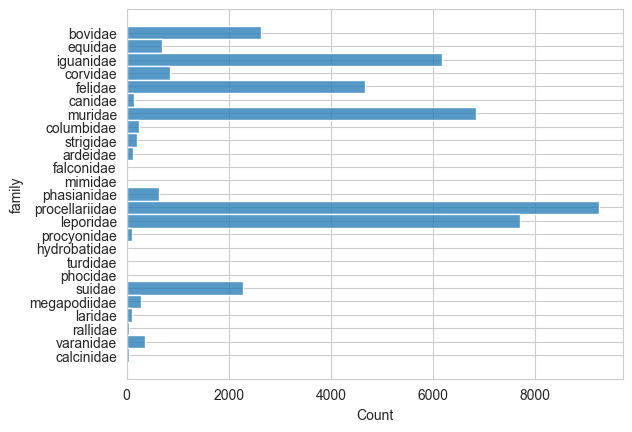

In [24]:
sns.histplot(df_single, y = 'family')

### Common Name version
Replace "rabbits and hares" with "rabbit or hare" and "typical iguanas" with "iguana", then create the imbalanced and lower-bounded subsets.


In [27]:
df_common = df_single.copy()
df_common.loc[df_common["common_name"] == "rabbits and hares", "common_name"] = "rabbit or hare"
df_common.loc[df_common["common_name"] == "typical iguanas", "common_name"] = "iguana"

### Filter to Family classifications

In [28]:
df_filter = df_single.loc[df_single["family"].notna()].copy()
df_filter[taxa_cols].info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 43423 entries, 0 to 44437
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   original_label   43423 non-null  object
 1   scientific_name  43423 non-null  object
 2   common_name      43423 non-null  object
 3   kingdom          43423 non-null  object
 4   phylum           43423 non-null  object
 5   class            43423 non-null  object
 6   order            43423 non-null  object
 7   family           43423 non-null  object
 8   genus            27449 non-null  object
 9   species          12728 non-null  object
dtypes: object(10)
memory usage: 3.6+ MB


### Remove extra columns

Only need `taxa_cols` (Linnean taxonomy + `original_label`, `scientific_name`, and `common_name`) and `id_cols`.

In [29]:
id_cols = ['dataset_name',
           'url_gcp',
           'url_aws',
           'url_azure',
           'image_id',
           'sequence_id',
           'location_id',
           'frame_num']

cols_to_keep = [col for col in list(df.columns) if (col in id_cols or col in taxa_cols)]

In [30]:
cols_to_keep

['dataset_name',
 'url_gcp',
 'url_aws',
 'url_azure',
 'image_id',
 'sequence_id',
 'location_id',
 'frame_num',
 'original_label',
 'scientific_name',
 'common_name',
 'kingdom',
 'phylum',
 'class',
 'order',
 'family',
 'genus',
 'species']

Let's add a number of images column (by `family` and by `common_name` for each subset).

In [31]:
for sci_name in list(df_filter["family"].unique()):
    df_filter.loc[df_filter["family"] == sci_name, "num_fam_images"] = df_filter.loc[df_filter["family"] == sci_name].shape[0]

df_filter.head()

dataset_name  \
0  Island Conservation Camera Traps   
1  Island Conservation Camera Traps   
2  Island Conservation Camera Traps   
3  Island Conservation Camera Traps   
4  Island Conservation Camera Traps   

                                             url_gcp  \
0  https://storage.googleapis.com/public-datasets...   
1  https://storage.googleapis.com/public-datasets...   
2  https://storage.googleapis.com/public-datasets...   
3  https://storage.googleapis.com/public-datasets...   
4  https://storage.googleapis.com/public-datasets...   

                                             url_aws  \
0  http://us-west-2.opendata.source.coop.s3.amazo...   
1  http://us-west-2.opendata.source.coop.s3.amazo...   
2  http://us-west-2.opendata.source.coop.s3.amazo...   
3  http://us-west-2.opendata.source.coop.s3.amazo...   
4  http://us-west-2.opendata.source.coop.s3.amazo...   

                                           url_azure  \
0  https://lilawildlife.blob.core.windows.net/lil...   
1  https://lilawildlife.blob.core.windows.net/lil...   
2  https://lilawildlife.blob.core.windows.net/lil...   
3  https://lilawildlife.blob.core.windows.net/lil...   
4  https://lilawildlife.blob.core.windows.net/lil...   

                                            image_id  \
0  Island Conservation Camera Traps : dominicanre...   
1  Island Conservation Camera Traps : dominicanre...   
2  Island Conservation Camera Traps : dominicanre...   
3  Island Conservation Camera Traps : dominicanre...   
4  Island Conservation Camera Traps : dominicanre...   

                                  sequence_id  \
0  Island Conservation Camera Traps : unknown   
1  Island Conservation Camera Traps : unknown   
2  Island Conservation Camera Traps : unknown   
3  Island Conservation Camera Traps : unknown   
4  Island Conservation Camera Traps : unknown   

                                         location_id  frame_num  \
0  Island Conservation Camera Traps : dominicanre...         -1   
1  Island Conservation Camera Traps : dominicanre...         -1   
2  Island Conservation Camera Traps : dominicanre...         -1   
3  Island Conservation Camera Traps : dominicanre...         -1   
4  Island Conservation Camera Traps : dominicanre...         -1   

  original_label scientific_name  ...     family subfamily   tribe   genus  \
0            cow      bos taurus  ...    bovidae   bovinae  bovini     bos   
1         donkey    equus asinus  ...    equidae       NaN     NaN   equus   
2         donkey    equus asinus  ...    equidae       NaN     NaN   equus   
3         iguana          iguana  ...  iguanidae       NaN     NaN  iguana   
4         iguana          iguana  ...  iguanidae       NaN     NaN  iguana   

        species subspecies variety multi_species num_species num_fam_images  
0    bos taurus        NaN     NaN         False         1.0         2635.0  
1  equus asinus        NaN     NaN         False         1.0          697.0  
2  equus asinus        NaN     NaN         False         1.0          697.0  
3           NaN        NaN     NaN         False         1.0         6163.0  
4           NaN        NaN     NaN         False         1.0         6163.0  

[5 rows x 35 columns]

In [32]:
for common_name in list(df_common["common_name"].unique()):
    df_common.loc[df_common["common_name"] == common_name, "num_cn_images"] = df_common.loc[df_common["common_name"] == common_name].shape[0]

df_common.head()

dataset_name  \
0  Island Conservation Camera Traps   
1  Island Conservation Camera Traps   
2  Island Conservation Camera Traps   
3  Island Conservation Camera Traps   
4  Island Conservation Camera Traps   

                                             url_gcp  \
0  https://storage.googleapis.com/public-datasets...   
1  https://storage.googleapis.com/public-datasets...   
2  https://storage.googleapis.com/public-datasets...   
3  https://storage.googleapis.com/public-datasets...   
4  https://storage.googleapis.com/public-datasets...   

                                             url_aws  \
0  http://us-west-2.opendata.source.coop.s3.amazo...   
1  http://us-west-2.opendata.source.coop.s3.amazo...   
2  http://us-west-2.opendata.source.coop.s3.amazo...   
3  http://us-west-2.opendata.source.coop.s3.amazo...   
4  http://us-west-2.opendata.source.coop.s3.amazo...   

                                           url_azure  \
0  https://lilawildlife.blob.core.windows.net/lil...   
1  https://lilawildlife.blob.core.windows.net/lil...   
2  https://lilawildlife.blob.core.windows.net/lil...   
3  https://lilawildlife.blob.core.windows.net/lil...   
4  https://lilawildlife.blob.core.windows.net/lil...   

                                            image_id  \
0  Island Conservation Camera Traps : dominicanre...   
1  Island Conservation Camera Traps : dominicanre...   
2  Island Conservation Camera Traps : dominicanre...   
3  Island Conservation Camera Traps : dominicanre...   
4  Island Conservation Camera Traps : dominicanre...   

                                  sequence_id  \
0  Island Conservation Camera Traps : unknown   
1  Island Conservation Camera Traps : unknown   
2  Island Conservation Camera Traps : unknown   
3  Island Conservation Camera Traps : unknown   
4  Island Conservation Camera Traps : unknown   

                                         location_id  frame_num  \
0  Island Conservation Camera Traps : dominicanre...         -1   
1  Island Conservation Camera Traps : dominicanre...         -1   
2  Island Conservation Camera Traps : dominicanre...         -1   
3  Island Conservation Camera Traps : dominicanre...         -1   
4  Island Conservation Camera Traps : dominicanre...         -1   

  original_label scientific_name  ...     family subfamily   tribe   genus  \
0            cow      bos taurus  ...    bovidae   bovinae  bovini     bos   
1         donkey    equus asinus  ...    equidae       NaN     NaN   equus   
2         donkey    equus asinus  ...    equidae       NaN     NaN   equus   
3         iguana          iguana  ...  iguanidae       NaN     NaN  iguana   
4         iguana          iguana  ...  iguanidae       NaN     NaN  iguana   

        species subspecies variety multi_species num_species num_cn_images  
0    bos taurus        NaN     NaN         False         1.0         129.0  
1  equus asinus        NaN     NaN         False         1.0         697.0  
2  equus asinus        NaN     NaN         False         1.0         697.0  
3           NaN        NaN     NaN         False         1.0        6163.0  
4           NaN        NaN     NaN         False         1.0        6163.0  

[5 rows x 35 columns]

In [33]:
cols_to_keep_common = [col for col in cols_to_keep]
cols_to_keep_common.append("num_cn_images")

In [34]:
cols_to_keep.append("num_fam_images")

In [35]:
df_reduced = df_filter[cols_to_keep].copy()
df_reduced.head()

dataset_name  \
0  Island Conservation Camera Traps   
1  Island Conservation Camera Traps   
2  Island Conservation Camera Traps   
3  Island Conservation Camera Traps   
4  Island Conservation Camera Traps   

                                             url_gcp  \
0  https://storage.googleapis.com/public-datasets...   
1  https://storage.googleapis.com/public-datasets...   
2  https://storage.googleapis.com/public-datasets...   
3  https://storage.googleapis.com/public-datasets...   
4  https://storage.googleapis.com/public-datasets...   

                                             url_aws  \
0  http://us-west-2.opendata.source.coop.s3.amazo...   
1  http://us-west-2.opendata.source.coop.s3.amazo...   
2  http://us-west-2.opendata.source.coop.s3.amazo...   
3  http://us-west-2.opendata.source.coop.s3.amazo...   
4  http://us-west-2.opendata.source.coop.s3.amazo...   

                                           url_azure  \
0  https://lilawildlife.blob.core.windows.net/lil...   
1  https://lilawildlife.blob.core.windows.net/lil...   
2  https://lilawildlife.blob.core.windows.net/lil...   
3  https://lilawildlife.blob.core.windows.net/lil...   
4  https://lilawildlife.blob.core.windows.net/lil...   

                                            image_id  \
0  Island Conservation Camera Traps : dominicanre...   
1  Island Conservation Camera Traps : dominicanre...   
2  Island Conservation Camera Traps : dominicanre...   
3  Island Conservation Camera Traps : dominicanre...   
4  Island Conservation Camera Traps : dominicanre...   

                                  sequence_id  \
0  Island Conservation Camera Traps : unknown   
1  Island Conservation Camera Traps : unknown   
2  Island Conservation Camera Traps : unknown   
3  Island Conservation Camera Traps : unknown   
4  Island Conservation Camera Traps : unknown   

                                         location_id  frame_num  \
0  Island Conservation Camera Traps : dominicanre...         -1   
1  Island Conservation Camera Traps : dominicanre...         -1   
2  Island Conservation Camera Traps : dominicanre...         -1   
3  Island Conservation Camera Traps : dominicanre...         -1   
4  Island Conservation Camera Traps : dominicanre...         -1   

  original_label scientific_name      common_name   kingdom    phylum  \
0            cow      bos taurus           cattle  animalia  chordata   
1         donkey    equus asinus           donkey  animalia  chordata   
2         donkey    equus asinus           donkey  animalia  chordata   
3         iguana          iguana  typical iguanas  animalia  chordata   
4         iguana          iguana  typical iguanas  animalia  chordata   

      class           order     family   genus       species  num_fam_images  
0  mammalia    artiodactyla    bovidae     bos    bos taurus          2635.0  
1  mammalia  perissodactyla    equidae   equus  equus asinus           697.0  
2  mammalia  perissodactyla    equidae   equus  equus asinus           697.0  
3  reptilia        squamata  iguanidae  iguana           NaN          6163.0  
4  reptilia        squamata  iguanidae  iguana           NaN          6163.0

In [36]:
df_reduced_common = df_common[cols_to_keep_common].copy()
df_reduced_common.head()

dataset_name  \
0  Island Conservation Camera Traps   
1  Island Conservation Camera Traps   
2  Island Conservation Camera Traps   
3  Island Conservation Camera Traps   
4  Island Conservation Camera Traps   

                                             url_gcp  \
0  https://storage.googleapis.com/public-datasets...   
1  https://storage.googleapis.com/public-datasets...   
2  https://storage.googleapis.com/public-datasets...   
3  https://storage.googleapis.com/public-datasets...   
4  https://storage.googleapis.com/public-datasets...   

                                             url_aws  \
0  http://us-west-2.opendata.source.coop.s3.amazo...   
1  http://us-west-2.opendata.source.coop.s3.amazo...   
2  http://us-west-2.opendata.source.coop.s3.amazo...   
3  http://us-west-2.opendata.source.coop.s3.amazo...   
4  http://us-west-2.opendata.source.coop.s3.amazo...   

                                           url_azure  \
0  https://lilawildlife.blob.core.windows.net/lil...   
1  https://lilawildlife.blob.core.windows.net/lil...   
2  https://lilawildlife.blob.core.windows.net/lil...   
3  https://lilawildlife.blob.core.windows.net/lil...   
4  https://lilawildlife.blob.core.windows.net/lil...   

                                            image_id  \
0  Island Conservation Camera Traps : dominicanre...   
1  Island Conservation Camera Traps : dominicanre...   
2  Island Conservation Camera Traps : dominicanre...   
3  Island Conservation Camera Traps : dominicanre...   
4  Island Conservation Camera Traps : dominicanre...   

                                  sequence_id  \
0  Island Conservation Camera Traps : unknown   
1  Island Conservation Camera Traps : unknown   
2  Island Conservation Camera Traps : unknown   
3  Island Conservation Camera Traps : unknown   
4  Island Conservation Camera Traps : unknown   

                                         location_id  frame_num  \
0  Island Conservation Camera Traps : dominicanre...         -1   
1  Island Conservation Camera Traps : dominicanre...         -1   
2  Island Conservation Camera Traps : dominicanre...         -1   
3  Island Conservation Camera Traps : dominicanre...         -1   
4  Island Conservation Camera Traps : dominicanre...         -1   

  original_label scientific_name common_name   kingdom    phylum     class  \
0            cow      bos taurus      cattle  animalia  chordata  mammalia   
1         donkey    equus asinus      donkey  animalia  chordata  mammalia   
2         donkey    equus asinus      donkey  animalia  chordata  mammalia   
3         iguana          iguana      iguana  animalia  chordata  reptilia   
4         iguana          iguana      iguana  animalia  chordata  reptilia   

            order     family   genus       species  num_cn_images  
0    artiodactyla    bovidae     bos    bos taurus          129.0  
1  perissodactyla    equidae   equus  equus asinus          697.0  
2  perissodactyla    equidae   equus  equus asinus          697.0  
3        squamata  iguanidae  iguana           NaN         6163.0  
4        squamata  iguanidae  iguana           NaN         6163.0

### Reduce to no more than 10K images per species

In [37]:
df_reduced_common["common_name"].value_counts()[:5]

common_name
rabbit or hare    7702
rat               6844
petrel            6538
iguana            6163
cat               4663
Name: count, dtype: int64

In [38]:
df_reduced.family.value_counts()[:5]

family
procellariidae    9245
leporidae         7702
muridae           6844
iguanidae         6163
felidae           4663
Name: count, dtype: int64

Both subsets are already under 10K.

In [39]:
df_reduced_common.to_csv("../data/potential-test-sets/filtered/island-imbalanced_common.csv", index = False)
df_reduced.to_csv("../data/potential-test-sets/filtered/island-imbalanced_family.csv", index = False)

In [40]:
df_reduced_common.loc[df_reduced_common["num_cn_images"] >= 10].to_csv("../data/potential-test-sets/filtered/island-lower-bound_common.csv", index = False)
df_reduced.loc[df_reduced["num_fam_images"] >= 10].to_csv("../data/potential-test-sets/filtered/island-lower-bound_family.csv", index = False)

<Axes: xlabel='Count', ylabel='common_name'>

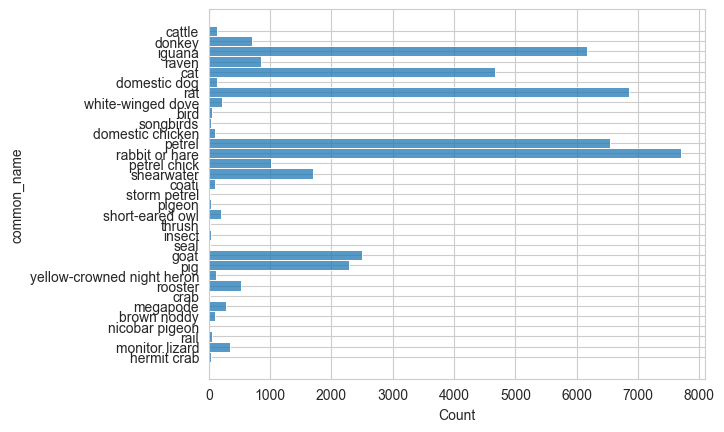

In [42]:
sns.histplot(df_reduced_common.loc[df_reduced_common["num_cn_images"] >= 10], y = "common_name")

### Randomly sample to balanced set (12 images per family)


In [43]:
balanced_set = []
for sci_name in list(df_reduced["family"].unique()):
    temp = df_reduced.loc[df_reduced["family"] == sci_name].copy()
    if temp.shape[0] < 12:
        continue
    sample_set = list(temp.sample(12, random_state = 614)["image_id"])
    balanced_set = balanced_set + sample_set

len(balanced_set)

288

Filter to just balanced set and drop the number of species column since it's been balanced to 12 each.

In [45]:
df_balanced = df_reduced.loc[df_reduced["image_id"].isin(balanced_set)].copy()
df_balanced.drop(columns = ["num_fam_images"], inplace = True)
df_balanced.to_csv("../data/potential-test-sets/filtered/island-balanced.csv", index = False)